In [1]:
import os
import tqdm
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show

import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression

from shapely.geometry import Point
import matplotlib.font_manager as fm 
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show

from xlrd import open_workbook
from collections import defaultdict

# 전체 데이터 요약
[전체 데이터 요약](https://s3-us-west-2.amazonaws.com/aistages-prod-server-public/app/Users/00000004/files/5942da61-46cd-4833-bdb3-e4cc9647fc6f..png)

## 1. 시청 시작 데이터 : history_data.csv
[시청 시작 데이터](https://s3-us-west-2.amazonaws.com/aistages-prod-server-public/app/Users/00000004/files/2b762359-78b9-470c-9369-5d1b3d9ff06f..png)

In [10]:
df = pd.read_csv('data/history_data.csv', engine='c', index_col=False)

df

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
0,3,20220301115653,20220301115719,MKID003,15,NaN,Y,N
1,3,20220301115653,20220301115809,MKID003,16,NaN,Y,N
2,3,20220301115653,20220301115958,MKID003,17,NaN,Y,N
3,3,20220301115653,20220301120118,MKID003,18,NaN,Y,N
4,3,20220301115653,20220301120229,MKID003,19,NaN,Y,N
...,...,...,...,...,...,...,...,...
1005646,33032,20220427155091,20220427155668,MKID003,381,NaN,Y,N
1005647,33032,20220427155091,20220427155680,MKID003,381,NaN,Y,N
1005648,33032,20220427155839,20220427155810,MKID003,125,NaN,Y,N
1005649,33032,20220427155706,20220427155838,MKID003,125,NaN,Y,N


### profile_id

In [46]:
# 결측값 확인

df_col = df.columns
df_nan = pd.DataFrame(index=['Null', 'Null percentage'], columns=df_col)

for c_name in df_col:
    df_nan[c_name] = [list(df[c_name].isnull()).count(True), 
                    "%.2f%%" % (list(df[c_name].isnull()).count(True)*100/len(df))]

df_nan

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
Null,0,0,0,0,0,932165,0,0
Null percentage,0.00%,0.00%,0.00%,0.00%,0.00%,92.69%,0.00%,0.00%


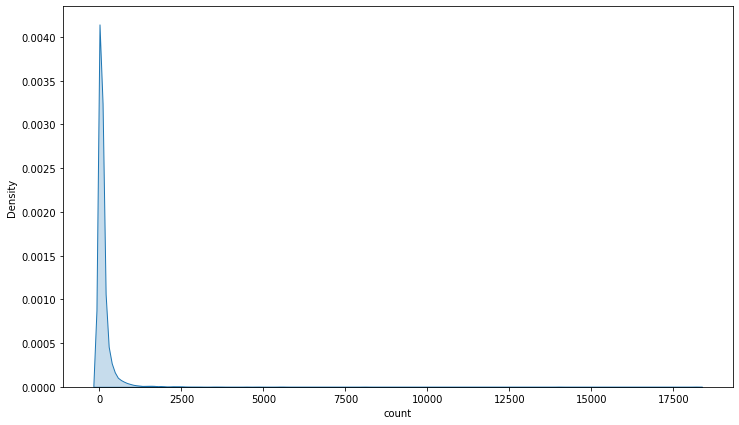

In [115]:
# 기록된 프로필 고유 ID 값 : 총 8311개

g = df['profile_id'].groupby(df['profile_id']).count()
g = g.reset_index(name='count')

fig, ax = plt.subplots(figsize=(12, 7))

sns.kdeplot(x='count', data=g, ax=ax, fill=True)

plt.show()


### ss_id

### payment

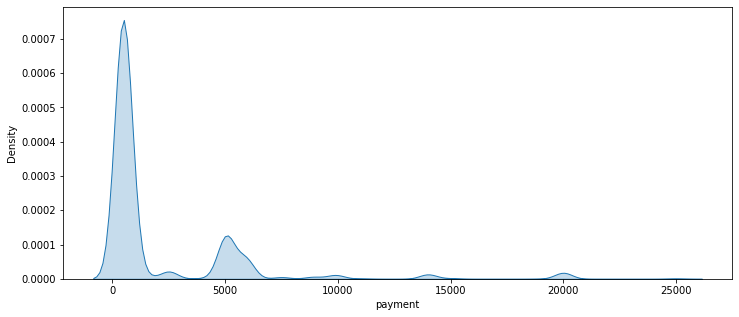

In [118]:
# 지불한 금액 범위 확인
df_1 = df[df['payment'].notnull()]
fig, ax = plt.subplots(1,1, figsize=(12, 5))

sns.kdeplot(x='payment', data=df_1, ax=ax, fill=True)

plt.show()